![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FMLOps%2FPipelines&file=Vertex+AI+Pipelines+-+Secret+Manager.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/MLOps/Pipelines/Vertex%20AI%20Pipelines%20-%20Secret%20Manager.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FMLOps%2FPipelines%2FVertex%2520AI%2520Pipelines%2520-%2520Secret%2520Manager.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/MLOps/Pipelines/Vertex%20AI%20Pipelines%20-%20Secret%20Manager.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/MLOps/Pipelines/Vertex%20AI%20Pipelines%20-%20Secret%20Manager.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

---
This is part of a [series of notebook based workflows](./readme.md) that teach all the ways to use pipelines within Vertex AI. The suggested order and description/reason is:

|Link To Section|Notebook Workflow|Description|
|---|---|---|
||[Vertex AI Pipelines - Start Here](./Vertex%20AI%20Pipelines%20-%20Start%20Here.ipynb)|What are pipelines? Start here to go from code to pipeline and see it in action.|
||[Vertex AI Pipelines - Introduction](./Vertex%20AI%20Pipelines%20-%20Introduction.ipynb)|Introduction to pipelines with the console and Vertex AI SDK|
||[Vertex AI Pipelines - Components](./Vertex%20AI%20Pipelines%20-%20Components.ipynb)|An introduction to all the ways to create pipeline components from your code|
||[Vertex AI Pipelines - IO](./Vertex%20AI%20Pipelines%20-%20IO.ipynb)|An overview of all the type of inputs and outputs for pipeline components|
||[Vertex AI Pipelines - Control](./Vertex%20AI%20Pipelines%20-%20Control.ipynb)|An overview of controlling the flow of exectution for pipelines|
||[Vertex AI Pipelines - Secret Manager](./Vertex%20AI%20Pipelines%20-%20Secret%20Manager.ipynb)|How to pass sensitive information to pipelines and components|
||[Vertex AI Pipelines - Scheduling](./Vertex%20AI%20Pipelines%20-%20Scheduling.ipynb)|How to schedule pipeline execution|
||[Vertex AI Pipelines - Notifications](./Vertex%20AI%20Pipelines%20-%20Notifications.ipynb)|How to send email notification of pipeline status.|
||[Vertex AI Pipelines - Management](./Vertex%20AI%20Pipelines%20-%20Management.ipynb)|Managing, Reusing, and Storing pipelines and components|
||[Vertex AI Pipelines - Testing](./Vertex%20AI%20Pipelines%20-%20Testing.ipynb)|Strategies for testing components and pipeliens locally and remotely to aide development.|


To discover these notebooks as part of an introduction to MLOps orchestration [start here](./readme.md).  To read more about MLOps also check out [the parent folder](../readme.md).

---

# Vertex AI Pipelines - Secret Manager

When working with [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) a component may need to access another service via an API key or other credential.  It is not a good practice to pass these types of credentials as parameters or to hard code them into a component.  Instead, the best practice of retrieving these from [Secret Manager](https://cloud.google.com/secret-manager/docs/create-secret-quickstart#secretmanager-quickstart-console) is described in this notebook based workflow.  

This workflow shows saving credentials in Secret Manager and then just passing the name of the secret to a component which then uses the Secret Manager Python Client to retrieve the credential at run time. This adds the benefit of being able to centrally managed credentials ensuring components are always retrieving the latest values.

**References**
- [Secret Manager Documentation](https://cloud.google.com/secret-manager/docs/create-secret-quickstart)
- [Secret Manager Python Client](https://cloud.google.com/python/docs/reference/secretmanager/latest)

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.secretmanager', 'google-cloud-secret-manager'),
    ('kfp', 'kfp')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable secretmanager.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Inputs

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
EXPERIMENT = 'pipeline-secret-manager'
SERIES = 'mlops'

# gcs bucket
GCS_BUCKET = PROJECT_ID

Packages

In [8]:
import os
import time
from google.cloud import aiplatform
from google.cloud import secretmanager
import kfp

Clients

In [9]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION)

# secret manager client
secret_client = secretmanager.SecretManagerServiceClient()

parameters:

In [10]:
DIR = f"temp/{SERIES}-{EXPERIMENT}"

In [11]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

environment:

In [12]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

## Secret Manager

[Secret Manager](https://cloud.google.com/secret-manager/docs/create-secret-quickstart#secretmanager-quickstart-console) as a Google Cloud tool for managing credentials with a wide array of interfaces for creating and retrieving.  This is an essential tool in MLOps to prevent exposing credential as parameters, hardcoding into code, or storing in storage location.  

### Create A Secret

You can [create a secret](https://cloud.google.com/secret-manager/docs/create-secret-quickstart#create_a_secret_and_access_a_secret_version) with the console or one of a number of clients.  Both the console and the Python client are used here for examples.

> Note: Replication
>
> The console defaults the replication policy to 'automatic' and the Python example below specified 'automatic' for the example. Read more about [choosing a replication policy](https://cloud.google.com/secret-manager/docs/choosing-replication).

**Console**
- Go to [console.cloud.google.com](https://console.cloud.google.com)
- Navigate to Security > Secret Manager: [direct link](https://console.cloud.google.com/security/secret-manager)
- Click **Create Secret**
    - Enter a name
    - Enter a secret value or upload from file
- Click **Create Secret**

Screenshot:

<p align="center" width="60%"><center>
    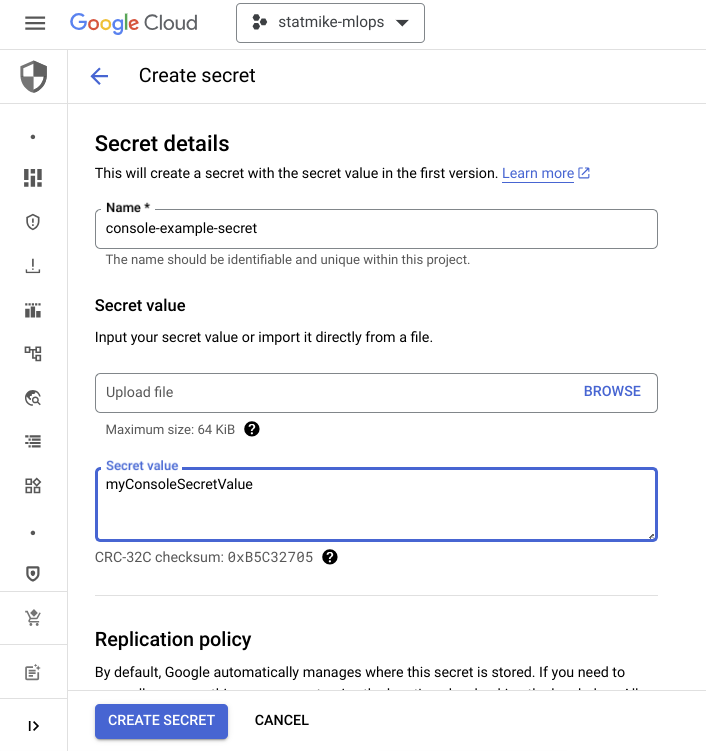
</center></p>

**Python Client**

In [20]:
try:
    # retrieve secret if it already exists:
    secret_version = secret_client.get_secret_version(
        name = f'projects/{PROJECT_ID}/secrets/python-example-secret/versions/latest'
    )
except Exception:
    # create secret if it does not already exists:
    secret = secret_client.create_secret(
        parent = f'projects/{PROJECT_ID}',
        secret_id = 'python-example-secret',
        secret = dict(replication = dict(automatic = dict()))
    )
    secret_version = secret_client.add_secret_version(
        parent = secret.name,
        payload = dict(data = b'myPythonSecretValue')
    )
    
print(secret_version.name)

projects/1026793852137/secrets/python-example-secret/versions/1


### Retrieve A Secret

Both secrets create above can be retrieve using the Python client:

In [22]:
secret_client.access_secret_version(
    name = f'projects/{PROJECT_ID}/secrets/console-example-secret/versions/latest'
).payload.data.decode('utf-8')

'myConsoleSecretValue'

In [23]:
secret_client.access_secret_version(
    name = f'projects/{PROJECT_ID}/secrets/python-example-secret/versions/latest'
).payload.data.decode('utf-8')

'myPythonSecretValue'

---
## Vertex AI Pipelines - Using Secret Manager

Pipeline components can be designed to retrieve secret values for secret manager.  The name of the secret can be passed to the pipeline as an input parameter.  The simple pipeline example below creates a [Lightweigth Python Component](https://www.kubeflow.org/docs/components/pipelines/v2/components/lightweight-python-components/)
that retrieve the secret based on the `secret_name` input parameter.

> Explore more component types in the companion workflow [Vertex AI Pipelines - Components](./Vertex%20AI%20Pipelines%20-%20Components.ipynb)

### Create Pipeline Components

These are simple Python components, specifically lightweight Python components.  For more details on the types of components check out this workflow in the same repository:
- [Vertex AI Pipelines - Components](./Vertex%20AI%20Pipelines%20-%20Components.ipynb)


Simple component that takes an input string, the `secret_name`, and retrieves the secret value.

In [24]:
@kfp.dsl.component(
    base_image = "python:3.10",
    packages_to_install = ["google-cloud-secret-manager"]
)
def example_component(project: str, secret_name: str) -> str:
    from google.cloud import secretmanager
    secret_client = secretmanager.SecretManagerServiceClient()
    
    try:
        secret_value = secret_client.access_secret_version(
            name = f'projects/{project}/secrets/{secret_name}/versions/latest'
        ).payload.data.decode('utf-8')
        secret_success = True
    except Exception:
        secret_success = False
        
    
    if secret_success:
        return 'Secret Retrieved Successfully'
    else:
        return 'Issue Encountered Retrieving Secret'

### Create Pipeline

In [25]:
@kfp.dsl.pipeline(
    name = f'{SERIES}-{EXPERIMENT}',
    description = 'A simple pipeline for testing secret retrieval',
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root'
)
def example_pipeline(
    project: str,
    secret_name: str
):
    task_with_secret = example_component(project = project, secret_name = secret_name)

### Compile Pipeline

In [26]:
kfp.compiler.Compiler().compile(
    pipeline_func = example_pipeline,
    package_path = f'{DIR}/{SERIES}-{EXPERIMENT}.yaml'
)

### Create Pipeline Job

In [27]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"{SERIES}-{EXPERIMENT}",
    template_path = f"{DIR}/{SERIES}-{EXPERIMENT}.yaml",
    parameter_values = dict(project = PROJECT_ID, secret_name = 'python-example-secret'),
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root',
    enable_caching = None # True (enabled), False (disable), None (defer to component level caching) 
)

### Submit Pipeline Job

In [28]:
response = pipeline_job.submit(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-secret-manager-20240503123948
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-secret-manager-20240503123948')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-secret-manager-20240503123948?project=1026793852137


In [31]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-secret-manager-20240503123948?project=1026793852137


In [32]:
pipeline_job.wait()

PipelineJob run completed. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-secret-manager-20240503123948


<p align="center" width="60%"><center>
    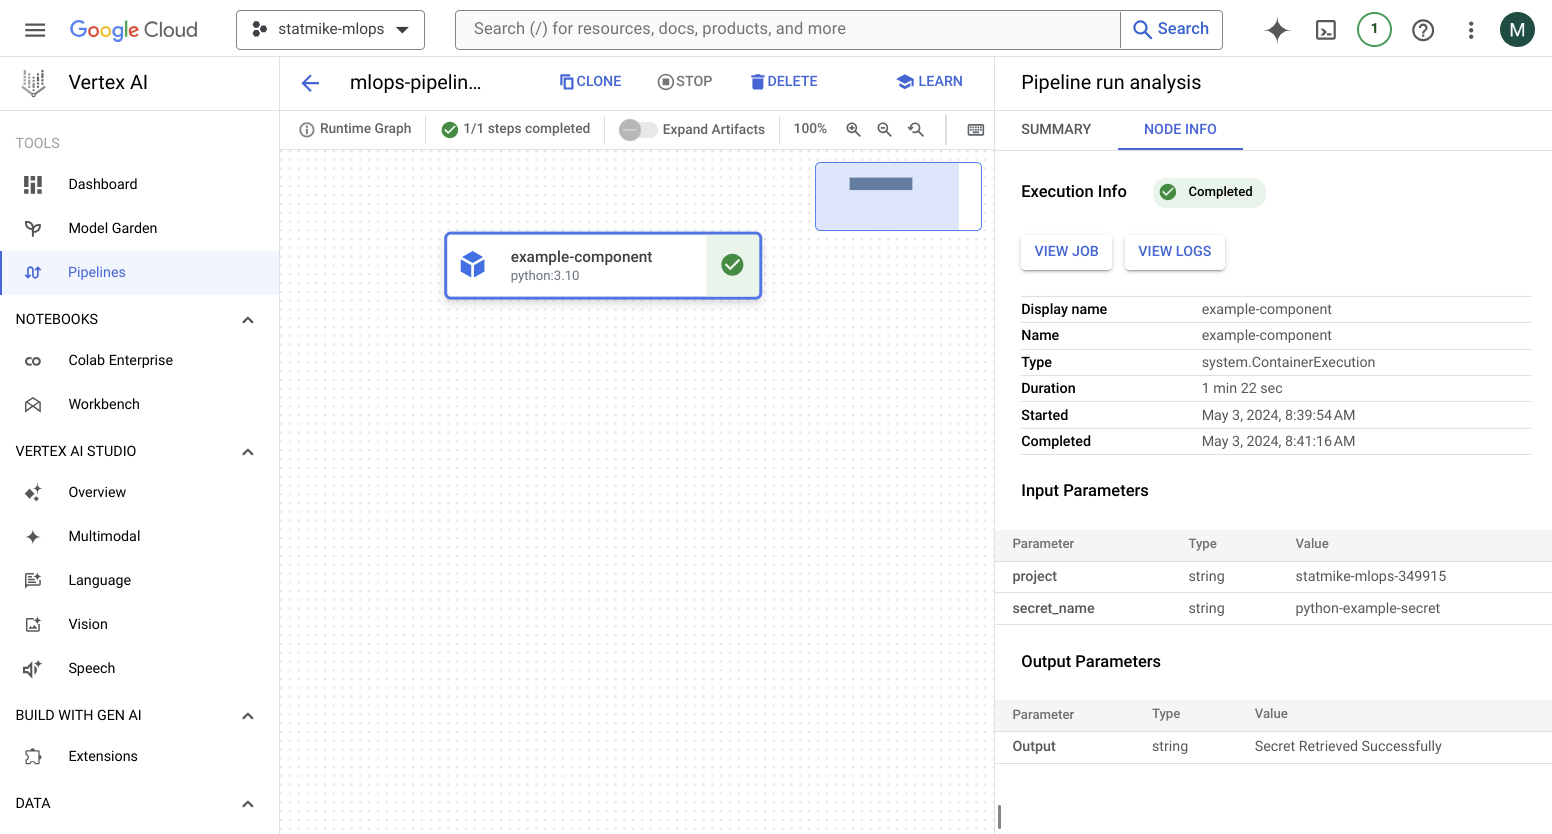
</center></p>

### Retrieve Pipeline Information

In [33]:
aiplatform.get_pipeline_df(pipeline = f'{SERIES}-{EXPERIMENT}')

,pipeline_name,run_name,param.input:project,param.input:secret_name,param.vmlmd_lineage_integration
0,mlops-pipeline-secret-manager,mlops-pipeline-secret-manager-20240503123948,statmike-mlops-349915,python-example-secret,{'pipeline_run_component': {'project_id': 'sta...


In [34]:
tasks = {task.task_name: task for task in pipeline_job.task_details}

In [35]:
for task in tasks:
  print(task, tasks[task].state)

example-component State.SUCCEEDED
mlops-pipeline-secret-manager-20240503123948 State.SUCCEEDED


In [36]:
for task in tasks:
    print(task)

example-component
mlops-pipeline-secret-manager-20240503123948


In [37]:
tasks['example-component']

task_id: 1784229813913911296
task_name: "example-component"
create_time {
  seconds: 1714739993
  nanos: 934511000
}
start_time {
  seconds: 1714739994
  nanos: 539903000
}
end_time {
  seconds: 1714740076
  nanos: 610213000
}
executor_detail {
  container_detail {
    main_job: "projects/1026793852137/locations/us-central1/customJobs/4127369322693656576"
  }
}
state: SUCCEEDED
execution {
  name: "projects/1026793852137/locations/us-central1/metadataStores/default/executions/5677880652596949240"
  display_name: "example-component"
  state: COMPLETE
  etag: "1714740076536"
  create_time {
    seconds: 1714739994
    nanos: 197000000
  }
  update_time {
    seconds: 1714740076
    nanos: 536000000
  }
  schema_title: "system.ContainerExecution"
  schema_version: "0.0.1"
  metadata {
    fields {
      key: "input:project"
      value {
        string_value: "statmike-mlops-349915"
      }
    }
    fields {
      key: "input:secret_name"
      value {
        string_value: "python-examp